In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import CausalInference
from pgmpy.models import BayesianNetwork

%load_ext lab_black
%load_ext watermark

# Supplementary Problem&mdash;Emily's Vacation

This is the first question on the Fall 2019 [practice midterm](https://www2.isye.gatech.edu/isye6420/exams.html).

-----------------------------

Emily is taking Bayesian Analysis course. She believes she will get an A with probability 0.6, a B with probability 0.3, and a C or less with probability 0.1. At the end of semester she will get a car as a present form her (very) rich uncle depending on her class performance. For getting an A in the course Emily will get a car with probability 0.8, for B with probability 0.5, and for anything less than B, she will get a car with probability of 0.2. These are the probabilities if the market is bullish. If the market is bearish, the uncle is less likely to make expensive presents, and the above probabilities are 0.5, 0.3, and 0.1, respectively. The probabilities of bullish and bearish market are equal, 0.5 each. If Emily gets a car and doesn't win the lottery[^1], she would travel to Redington Shores with probability 0.7, or stay on campus with probability 0.3. If she does not get a car, these two probabilities are 0.2 and 0.8, respectively. 

Independently, Emily may be a lucky winner of a sweepstake lottery for a free air ticket and vacation in hotel Sol at Redington Shores. The chance to win the sweepstake is 0.001, but if Emily wins, she will go to vacation with probability of 0.99, irrespective of what happened with the car.

After the semester was over you learned that Emily is at Redington Shores.

1. What is the probability that she got a car?

2. What is the probability that she won the sweepstakes?

3. What is the probability that she got a B in the course?

4. What is the probability that the market was bearish?

Hint: You can solve this problem by any of the 3 ways: (i) use of WinBUGS or OpenBUGS, (ii) direct simulation using Octave/MATLAB, R, or Python, and (iii) exact calculation. Use just one of the three ways to solve it. WinBUGS/OpenBUGS or direct simulation are recommended. The exact solution, although straightforward, may be quite messy.

[^1]: I edited this line from the original for clarity based on student feedback.

----------------

This is a bit more complicated than [](./Unit3-Alarm.ipynb), but still pretty easy with pgmpy. The only tricky part is making sure you've entered everything in the correct order.


When defining variables in pgmpy, the columns are evidence, the rows are the states of the variable. The order you enter evidence matters. See the comments above the ```cpd_car``` and ```cpd_vacation``` variables. I'm going to use the ```state_names``` parameter of ```TabularCPD()``` to help keep track of what's going on here. 

In [2]:
# Defining network structure
emily_model = BayesianNetwork(
    [
        ("Grade", "Car"),
        ("Car", "Vacation"),
        ("Sweepstakes", "Vacation"),
        ("Market", "Car"),
    ]
)

# Defining the variables
cpd_market = TabularCPD(
    variable="Market",
    variable_card=2,
    values=[[0.5], [0.5]],
    state_names={"Market": ["Bull", "Bear"]},
)

cpd_grade = TabularCPD(
    variable="Grade",
    variable_card=3,
    values=[[0.6], [0.3], [0.1]],
    state_names={"Grade": ["A", "B", "C"]},
)

#    Car variable
#    +---------+---------+---------+---------+---------+---------+---------+
#    | Market  | Bull    | Bull    | Bull    | Bear    | Bear    | Bear    |
#    +---------+---------+---------+---------+---------+---------+---------+
#    | Grade   | A       | B       | C       | A       | B       | C       |
#    +---------+---------+---------+---------+---------+---------+---------+
#    | Car     | 0.8     | 0.5     | 0.2     | 0.5     | 0.3     | 0.1     |
#    +---------+---------+---------+---------+---------+---------+---------+
#    | No car  | 0.2     | 0.5     | 0.8     | 0.5     | 0.7     | 0.9     |
#    +---------+---------+---------+---------+---------+---------+---------+

cpd_car = TabularCPD(
    variable="Car",
    variable_card=2,  # there are two possible outcomes, car or no car
    values=[
        [0.8, 0.5, 0.2, 0.5, 0.3, 0.1],  # car
        [0.2, 0.5, 0.8, 0.5, 0.7, 0.9],  # no car
    ],
    evidence=["Market", "Grade"],
    evidence_card=[2, 3],  # 2 possible states for the market, 3 for grade
    state_names={
        "Market": ["Bull", "Bear"],
        "Grade": ["A", "B", "C"],
        "Car": ["Yes", "No"],
    },
)

cpd_sweepstakes = TabularCPD(
    variable="Sweepstakes",
    variable_card=2,
    values=[[0.001], [0.999]],
    state_names={"Sweepstakes": ["Win", "Lose"]},
)

#    +----------------+---------+---------+---------+---------+
#    | Sweepstakes    | Win     | Win     | Lose    | Lose    |
#    +----------------+---------+---------+---------+---------+
#    | Car            | Yes     | No      | Yes     | No      |
#    +----------------+---------+---------+---------+---------+
#    | Vacation (yes) | 0.99    | 0.99    | 0.7     | 0.2     |
#    +----------------+---------+---------+---------+---------+
#    | Vacation (no)  | 0.01    | 0.01    | 0.3     | 0.8     |
#    +----------------+---------+---------+---------+---------+

cpd_vacation = TabularCPD(
    variable="Vacation",
    variable_card=2,
    values=[
        [0.99, 0.99, 0.7, 0.2],  # vacation
        [0.01, 0.01, 0.3, 0.8],  # no vacation
    ],
    evidence=["Sweepstakes", "Car"],
    evidence_card=[2, 2],
    state_names={
        "Sweepstakes": ["Win", "Lose"],
        "Car": ["Yes", "No"],
        "Vacation": ["Yes", "No"],
    },
)

# Associating the parameters with the model structure
emily_model.add_cpds(cpd_market, cpd_grade, cpd_car, cpd_sweepstakes, cpd_vacation)

emily_model.check_model()

print(f"Nodes: {emily_model.nodes()}")
print(f"Edges: {emily_model.edges()}")

Nodes: ['Grade', 'Car', 'Vacation', 'Sweepstakes', 'Market']
Edges: [('Grade', 'Car'), ('Car', 'Vacation'), ('Sweepstakes', 'Vacation'), ('Market', 'Car')]


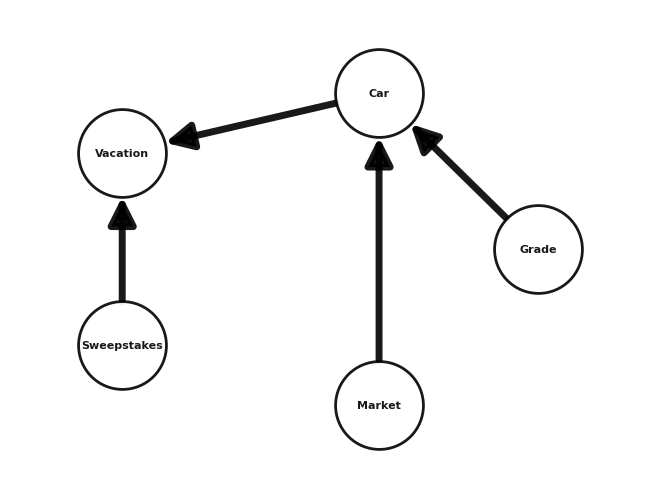

In [3]:
# plot the network

options = {
    "arrowsize": 40,
    "font_size": 8,
    "font_weight": "bold",
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 5,
    "alpha": 0.9,
}

nx.draw_circular(emily_model, with_labels=True, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

If the above network makes sense, we're good to go! Remember, we know Emily did go to Redington Shores for her vacation, so everything is conditional on that.

In [4]:
emily_infer = CausalInference(emily_model)

evidence = {"Vacation": "Yes"}

# a: probability Emily got a car.
q = emily_infer.query(variables=["Car"], evidence=evidence)
print("P(C|V):")
print(q)

# b: probability she won the sweepstakes.
q = emily_infer.query(variables=["Sweepstakes"], evidence=evidence)
print("P(SS|V):")
print(q)

# c: probability she got a B.
q = emily_infer.query(variables=["Grade"], evidence=evidence)
print("P(G|V):")
print(q)

# d: probability the stock market was bearish
q = emily_infer.query(variables=["Market"], evidence=evidence)
print("P(SM|V):")
print(q)

P(C|V):
+----------+------------+
| Car      |   phi(Car) |
+==========+============+
| Car(Yes) |     0.7940 |
+----------+------------+
| Car(No)  |     0.2060 |
+----------+------------+
P(SS|V):
+-------------------+--------------------+
| Sweepstakes       |   phi(Sweepstakes) |
+===================+====================+
| Sweepstakes(Win)  |             0.0021 |
+-------------------+--------------------+
| Sweepstakes(Lose) |             0.9979 |
+-------------------+--------------------+
P(G|V):
+----------+--------------+
| Grade    |   phi(Grade) |
+==========+==============+
| Grade(A) |       0.6809 |
+----------+--------------+
| Grade(B) |       0.2595 |
+----------+--------------+
| Grade(C) |       0.0595 |
+----------+--------------+
P(SM|V):
+--------------+---------------+
| Market       |   phi(Market) |
+==============+===============+
| Market(Bull) |        0.5674 |
+--------------+---------------+
| Market(Bear) |        0.4326 |
+--------------+---------------+


In [5]:
%watermark -n -u -v -iv

Last updated: Mon Mar 06 2023

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.11.0

networkx  : 3.0
matplotlib: 3.7.0

